# ENEL 645 Assignment 2
Group 11 Team Members: Steven Au, Laurel Flanagan, Rhys Wickens, Austen Zhang

## Image Classification Transfer Learning
Pre-trained Model: Efficient Net V2 S (https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_v2_s.html#torchvision.models.efficientnet_v2_s)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os


# Define data directories
data_dir = "/content/drive/MyDrive/Colab Notebooks/ENEL 645/CVPR_2024_dataset_Subset" #UPDATE DIRECTORY
# data_dir = r"C:\Users\rhysw\OneDrive\Documents\UofC Masters\Winter\ENEL 645\Assignments\A2" #UPDATE DIRECTORY
train_dir = os.path.join(data_dir, "CVPR_2024_dataset_Train")
val_dir = os.path.join(data_dir, "CVPR_2024_dataset_Val")
test_dir = os.path.join(data_dir, "CVPR_2024_dataset_Test")

# Define transformations
transform = {
    "train": transforms.Compose([
        models.EfficientNet_V2_S_Weights.IMAGENET1K_V1.transforms(), # This includes the following preprocessing: The images are resized to resize_size=[384] using interpolation=InterpolationMode.BILINEAR,
        # followed by a central crop of crop_size=[384]. Finally, the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]
        transforms.RandomHorizontalFlip(), # additional data augmentation step added to training data set
    ]),
    "val": models.EfficientNet_V2_S_Weights.IMAGENET1K_V1.transforms(),
    "test": models.EfficientNet_V2_S_Weights.IMAGENET1K_V1.transforms(),
}

# Load datasets
datasets = {
    "train": datasets.ImageFolder(train_dir, transform=transform["train"]), #converts Image folder into PyTorch dataset
    "val": datasets.ImageFolder(val_dir, transform=transform["val"]),
    "test": datasets.ImageFolder(test_dir, transform=transform["test"]),
}

# Define data loaders
dataloaders = {
    "train": DataLoader(datasets["train"], batch_size=128, shuffle=True, num_workers=4),
    "val": DataLoader(datasets["val"], batch_size=128, shuffle=False, num_workers=4),
    "test": DataLoader(datasets["test"], batch_size=128, shuffle=False, num_workers=4),

}

# Load the pre-trained EfficientNet_V2_S model with recommended weights
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)

# Freeze all layers except the last classifier
for param in model.features.parameters():
    param.requires_grad = False

# Modify the classifier for 4-class classification
num_features = model.classifier[1].in_features # input size for last fully connected layer
model.classifier[1] = nn.Linear(num_features, 4) # output size of 4 classes

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001) # optimize parameters of classifier, not feature extraction layers

# Training function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval() # turns off layers not needed during prediction, like dropout layer

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), "best_model.pth")

    print(f"Best val Acc: {best_acc:.4f}")
    return model

# Train the model
model = train_model(model, dataloaders, criterion, optimizer, num_epochs=20)

# Test function
def test_model(model, dataloader):
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) # use max function to get exact label
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Evaluate the model on the test set
test_model(model, dataloaders["test"])

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to C:\Users\rhysw/.cache\torch\hub\checkpoints\efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:06<00:00, 14.0MB/s]


Epoch 1/20
train Loss: 1.3184 Acc: 0.3830
val Loss: 1.2754 Acc: 0.4545
Epoch 2/20
train Loss: 1.1786 Acc: 0.4731
val Loss: 1.1917 Acc: 0.6477
Epoch 3/20
train Loss: 1.0860 Acc: 0.5754
val Loss: 1.1136 Acc: 0.6477
Epoch 4/20
train Loss: 1.0211 Acc: 0.6603
val Loss: 1.0411 Acc: 0.6818
Epoch 5/20
train Loss: 0.9580 Acc: 0.6620
val Loss: 0.9873 Acc: 0.6932
Epoch 6/20
train Loss: 0.9145 Acc: 0.6898
val Loss: 0.9621 Acc: 0.6591
Epoch 7/20
train Loss: 0.8503 Acc: 0.6967
val Loss: 0.9268 Acc: 0.6705
Epoch 8/20
train Loss: 0.8257 Acc: 0.7227
val Loss: 0.9133 Acc: 0.6705
Epoch 9/20
train Loss: 0.8101 Acc: 0.7175
val Loss: 0.8939 Acc: 0.6932
Epoch 10/20
train Loss: 0.7831 Acc: 0.7383
val Loss: 0.8749 Acc: 0.6932
Epoch 11/20
train Loss: 0.7583 Acc: 0.7383
val Loss: 0.8663 Acc: 0.7045
Epoch 12/20
train Loss: 0.7296 Acc: 0.7435
val Loss: 0.8557 Acc: 0.6932
Epoch 13/20
train Loss: 0.7075 Acc: 0.7591
val Loss: 0.8490 Acc: 0.6932
Epoch 14/20
train Loss: 0.6759 Acc: 0.7626
val Loss: 0.8472 Acc: 0.6932
E

C:\Users\rhysw\AppData\Local\Temp\ipykernel_27800\3417665594.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Test Accuracy: 56.80%


## Text Classification Transfer Learning
Pre-trained model: DistilBERT Classifier

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertModel, DistilBertTokenizer
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [6]:
# Define functions

# Extract text from file names as well as labels
def read_text_files_with_labels(path):
    texts = []
    labels = []
    class_folders = sorted(os.listdir(path))  # Assuming class folders are sorted
    label_map = {class_name: idx for idx, class_name in enumerate(class_folders)}

    for class_name in class_folders:
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            file_names = os.listdir(class_path)
            for file_name in file_names:
                file_path = os.path.join(class_path, file_name)
                if os.path.isfile(file_path):
                    file_name_no_ext, _ = os.path.splitext(file_name)
                    text = file_name_no_ext.replace('_', ' ')
                    text_without_digits = re.sub(r'\d+', '', text)
                    texts.append(text_without_digits)
                    labels.append(label_map[class_name])

    return np.array(texts), np.array(labels)

# Define your dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Define the model
class DistilBERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DistilBERTClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(self.distilbert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)[0]
        output = self.drop(pooled_output[:,0])
        return self.out(output)

# Define training function
def train(model, iterator, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in iterator:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        output = model(input_ids, attention_mask)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(iterator)

# Define evaluation function
def evaluate(model, iterator, criterion, device):
    model.eval() # set model to evaluation model
    total_loss = 0
    with torch.no_grad(): # don't need dropout to be active so we disable gradients
        for batch in iterator:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            output = model(input_ids, attention_mask)
            loss = criterion(output, labels)

            total_loss += loss.item()

    return total_loss / len(iterator)

# Define prediction function
def predict(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    with torch.no_grad():  # Disable gradient tracking
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)  # Assuming input_ids are in the batch
            attention_mask = batch['attention_mask'].to(device)  # Assuming attention_mask is in the batch

            # Forward pass
            outputs = model(input_ids, attention_mask)

            # Get predictions
            _, preds = torch.max(outputs, dim=1)

            # Convert predictions to CPU and append to the list
            predictions.extend(preds.cpu().numpy())

    return predictions

In [7]:
# Use the paths for the data from the image classification

text_train,labels_train = read_text_files_with_labels(train_dir)
text_val,labels_val = read_text_files_with_labels(val_dir)
text_test,labels_test = read_text_files_with_labels(test_dir)

In [ ]:
# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize data
max_len = 24
dataset_train = CustomDataset(text_train, labels_train, tokenizer, max_len)
dataset_val = CustomDataset(text_val, labels_val, tokenizer, max_len)
dataset_test = CustomDataset(text_test, labels_test, tokenizer, max_len)

# Data loaders
train_loader = DataLoader(dataset_train, batch_size=128, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=128, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=128, shuffle=False)

best_loss = 1e+10 # best loss tracker
EPOCHS = 4

# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
text_model = DistilBERTClassifier(num_classes=4).to(device)

# Training parameters
optimizer = optim.Adam(text_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(EPOCHS):
    train_loss = train(text_model, train_loader, optimizer, criterion, device)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}')
    val_loss = evaluate(text_model, val_loader, criterion, device)
    print(f'Epoch: {epoch+1}, Val Loss: {val_loss:.4f}')
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(text_model.state_dict(), 'best_model.pth')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\rhysw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rhysw\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch: 1, Train Loss: 1.2118
Epoch: 1, Val Loss: 0.9150
Epoch: 2, Train Loss: 0.7579
Epoch: 2, Val Loss: 0.5738
Epoch: 3, Train Loss: 0.4443
Epoch: 3, Val Loss: 0.5192
Epoch: 4, Train Loss: 0.2504
Epoch: 4, Val Loss: 0.5777


In [9]:
text_model.load_state_dict(torch.load('best_model.pth'))
# Evaluation
test_predictions = predict(text_model, test_loader, device)
print(f"Accuracy:  {(test_predictions == labels_test).sum()/labels_test.size:.4f}")

C:\Users\rhysw\AppData\Local\Temp\ipykernel_27800\2595054650.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  text_model.load_state_dict(torch.load('best_model.pth'))


Accuracy:  0.7811


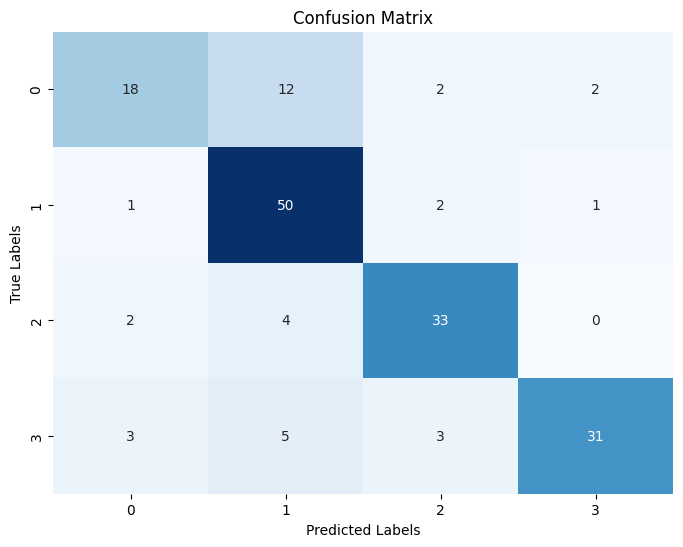

In [10]:
cm = confusion_matrix(labels_test, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()